In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))


CUDA available: True
Device name: NVIDIA L4


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt


# --- 정책 신경망 ---
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


# --- 가치 신경망 ---
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# --- 에이전트 클래스 ---
class ACAgent:
    def __init__(self, state_dim, action_size):
        self.gamma = 0.98
        self.lr_pi = 0.0002
        self.lr_v  = 0.0005

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = PolicyNetwork(state_dim, action_size).to(self.device)
        self.value_net  = ValueNetwork(state_dim).to(self.device)

        self.optimizer_pi = optim.Adam(self.policy_net.parameters(), lr = self.lr_pi)
        self.optimizer_v  = optim.Adam(self.value_net.parameters(),  lr = self.lr_v)

        # self.memory = []  # (log_prob, reward)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # (1, state_dim)
        probs = self.policy_net(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    # def add(self, log_prob, reward):
    #     self.memory.append((log_prob, reward))

    def update(self, state, action_log_prob, reward, next_state, done):
        # 배치 처리용 축 추가
        state       = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        next_state  = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)

        # 가치 함수의 손실 계산
        target = reward + (1 - done) * self.gamma * self.value_net(next_state) # TD 목표
        target = target.detach()

        v = self.value_net(state) # 현재 상태의 가치 함수
        loss_v = F.mse_loss(v, target) # 두 값의 평균 제곱 오차

        # 정책 함수의 손실 계산
        delta = target - v
        delta = delta.detach()

        loss_pi = -action_log_prob * delta

        # 신경망 학습
        self.optimizer_v.zero_grad()
        self.optimizer_pi.zero_grad()
        # self.value_net.zero_grad()
        # self.policy_net.zero_grad()

        loss_v.backward()
        loss_pi.backward()

        self.optimizer_v.step()
        self.optimizer_pi.step()

Using device: cuda
Episode 100, Reward: 10.0
Episode 200, Reward: 21.0
Episode 300, Reward: 63.0
Episode 400, Reward: 96.0
Episode 500, Reward: 135.0
Episode 600, Reward: 126.0
Episode 700, Reward: 117.0
Episode 800, Reward: 373.0
Episode 900, Reward: 423.0
Episode 1000, Reward: 265.0
Episode 1100, Reward: 500.0
Episode 1200, Reward: 173.0
Episode 1300, Reward: 230.0
Episode 1400, Reward: 206.0
Episode 1500, Reward: 12.0
Episode 1600, Reward: 90.0
Episode 1700, Reward: 266.0
Episode 1800, Reward: 114.0
Episode 1900, Reward: 378.0
Episode 2000, Reward: 151.0
Episode 2100, Reward: 369.0
Episode 2200, Reward: 281.0
Episode 2300, Reward: 269.0
Episode 2400, Reward: 308.0
Episode 2500, Reward: 110.0
Episode 2600, Reward: 327.0
Episode 2700, Reward: 203.0
Episode 2800, Reward: 148.0
Episode 2900, Reward: 233.0
Episode 3000, Reward: 311.0


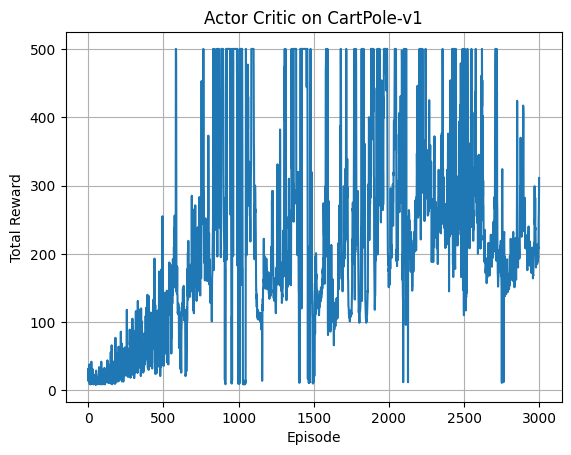

In [4]:
# --- 학습 루프 ---
def train(episodes=3000, render=False):
    env = gym.make('CartPole-v1', render_mode="rgb_array" if render else None)
    state_dim = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = ACAgent(state_dim, action_size)
    reward_history = []

    print("Using device:", agent.device)

    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Actor-Critic은 매 스텝마다 update
            agent.update(state, log_prob, reward, next_state, done)

            state = next_state
            total_reward += reward

        reward_history.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Reward: {total_reward}")

    env.close()

    # --- 시각화 ---
    plt.plot(reward_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Actor Critic on CartPole-v1")
    plt.grid()
    plt.show()


if __name__ == "__main__":
    train(episodes=3000)
